In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Create Label Variable

In [6]:
labels = os.listdir(r"/content/drive/MyDrive/DrowsiScan/train/data")

In [7]:
labels
#Show label and create labels variable

['yawn', 'Open', 'Closed', 'no_yawn']

## Show a random image

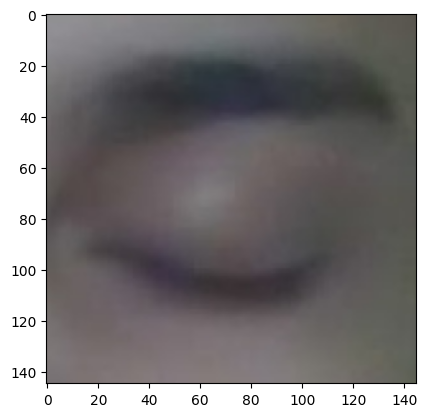

In [8]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"/content/drive/MyDrive/DrowsiScan/train/data/Closed/_3.jpg"))

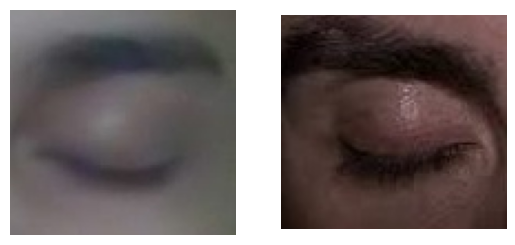

In [9]:


# Load and display multiple images
image_paths = [r"/content/drive/MyDrive/DrowsiScan/train/data/Closed/_3.jpg", r"/content/drive/MyDrive/DrowsiScan/train/data/Closed/_20.jpg"]

num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images)

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Create a and show Image array

In [10]:
a = plt.imread(r"/content/drive/MyDrive/DrowsiScan/train/data/yawn/10.jpg")

## Image shape

In [11]:
a.shape

(480, 640, 3)

## Display the image of a yawning face without the background, using the array representation of the face image.


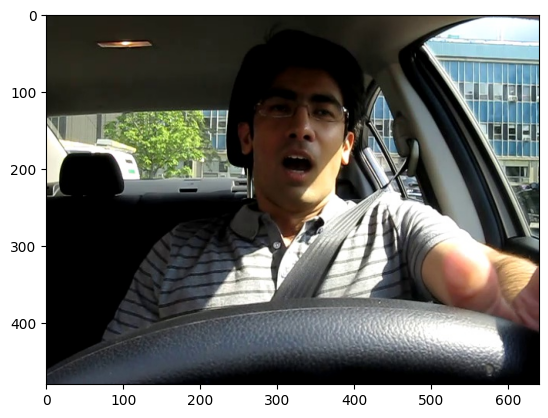

In [12]:
plt.imshow(plt.imread(r"/content/drive/MyDrive/DrowsiScan/train/data/yawn/59.jpg"))

## Extract only the face region from both yawn and not_yawn images.

In [13]:
def face_for_yawn(direc=r"/content/drive/MyDrive/DrowsiScan/train/data", face_cas_path=r"/content/drive/MyDrive/DrowsiScan/model/haarcascade/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            try:
                image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
            except Exception as e:
                print(f"Error processing image {image}: {e}")

    return yaw_no

## For Closed and Open eye

In [14]:
def get_data(dir_path=r"/content/drive/MyDrive/DrowsiScan/train/data"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label) + 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")

    return data

## Expand the dataset by adding more data and convert the data into an array format.

In [15]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)

    # Ensure all images and labels are correctly formatted
    images = []
    labels = []

    for item in yaw_no:
        images.append(item[0])
        labels.append(item[1])

    return np.array(images), np.array(labels)

## New variable to store

In [16]:
new_images, new_labels = append_data()
print("Data shape:", new_images.shape, new_labels.shape)

0
1
2
3
Data shape: (1925, 145, 145, 3) (1925,)


## Separate the labels and features in the dataset

## Reshape images X

In [17]:
X = np.array(new_images)
X = X.reshape(-1, 145, 145, 3)

In [18]:
X.shape

(1925, 145, 145, 3)

## Perform label binarization.

In [19]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(new_labels)

## Label array

In [20]:
y = np.array(y)

In [21]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Train Test split

In [22]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [23]:
len(X_test)

578

## Import some dependencies

In [25]:
from tensorflow.python.keras.layers import Lambda, Dropout
from tensorflow.python.keras.layers.advanced_activations import ELU, LeakyReLU, ReLU
from tensorflow.python.keras import activations
from keras import callbacks, layers, metrics, regularizers
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation,SimpleRNN
import cv2
import os
import numpy as np
import pandas as pd
import pickle


## Data Augmentation

In [26]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Build and train CNN model

In [27]:
model_CNN = keras.models.Sequential()

model_CNN.add(Conv2D(filters= 256, kernel_size=(3, 3), activation="relu", input_shape=(145,145,3)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 128, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 64, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 32, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(keras.layers.Flatten())
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))

model_CNN.add(keras.layers.Dense(64, activation="relu"))
model_CNN.add(keras.layers.Dense(4, activation="softmax"))

model_CNN.build(input_shape=(None, 145, 145, 3))
model_CNN.summary()

model_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 143, 143, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 69, 69, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1568)                │           6,272 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,332 (1.92 MB)

 Trainable params: 499,236 (1.90 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [28]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/DrowsiScan/train/history_and_model/best_model_CNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [29]:
history_CNN = model_CNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5958 - loss: 1.1942

43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 482ms/step - accuracy: 0.5983 - loss: 1.1863 - val_accuracy: 0.6003 - val_loss: 0.9884
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8223 - loss: 0.4759 - val_accuracy: 0.4481 - val_loss: 1.1097
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.8665 - loss: 0.3524 - val_accuracy: 0.4083 - val_loss: 1.2540
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8685 - loss: 0.3839 - val_accuracy: 0.5692 - val_loss: 1.2882
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8644 - loss: 0.3410

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8649 - loss: 0.3404 - val_accuracy: 0.5381 - val_loss: 0.9468
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.8894 - loss: 0.2692 - val_accuracy: 0.3789 - val_loss: 2.3216
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8769 - loss: 0.2940 - val_accuracy: 0.4360 - val_loss: 1.6511
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9205 - loss: 0.2231

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.9202 - loss: 0.2238 - val_accuracy: 0.7215 - val_loss: 0.6145
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9045 - loss: 0.2106

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9045 - loss: 0.2109 - val_accuracy: 0.7872 - val_loss: 0.5421
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9120 - loss: 0.2551 - val_accuracy: 0.7059 - val_loss: 0.7192
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9111 - loss: 0.2319

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.9111 - loss: 0.2315 - val_accuracy: 0.8166 - val_loss: 0.4749
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9252 - loss: 0.1768

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9250 - loss: 0.1775 - val_accuracy: 0.8270 - val_loss: 0.4050
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9128 - loss: 0.2288

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9128 - loss: 0.2286 - val_accuracy: 0.8720 - val_loss: 0.3225
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9237 - loss: 0.1953

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.9236 - loss: 0.1959 - val_accuracy: 0.8702 - val_loss: 0.2860
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9286 - loss: 0.1755

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.9283 - loss: 0.1762 - val_accuracy: 0.9152 - val_loss: 0.1963
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9242 - loss: 0.2067

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.9244 - loss: 0.2064 - val_accuracy: 0.9256 - val_loss: 0.1910
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9288 - loss: 0.1578

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9290 - loss: 0.1577 - val_accuracy: 0.9360 - val_loss: 0.1727
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9532 - loss: 0.1483 - val_accuracy: 0.9187 - val_loss: 0.1868
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9402 - loss: 0.1463 - val_accuracy: 0.9118 - val_loss: 0.1923
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9481 - loss: 0.1326

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9480 - loss: 0.1327 - val_accuracy: 0.9464 - val_loss: 0.1275
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9487 - loss: 0.1277 - val_accuracy: 0.9377 - val_loss: 0.1691
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9504 - loss: 0.1465 - val_accuracy: 0.9204 - val_loss: 0.1864
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.9448 - loss: 0.1303 - val_accuracy: 0.9377 - val_loss: 0.1701
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9503 - loss: 0.1198 - val_accuracy: 0.9273 - val_loss: 0.1766
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.9522 - loss: 0.1215 - val_accuracy: 0.9291 - val_loss: 0.1758
Epoch 26/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9440 - loss: 0.1223

43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.9440 - loss: 0.1223 - val_accuracy: 0.9498 - val_loss: 0.1138
Epoch 27/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9599 - loss: 0.0877 - val_accuracy: 0.8685 - val_loss: 0.3255
Epoch 28/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9509 - loss: 0.1441 - val_accuracy: 0.9446 - val_loss: 0.1281
Epoch 29/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9423 - loss: 0.1355 - val_accuracy: 0.9221 - val_loss: 0.2438
Epoch 30/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9530 - loss: 0.1074 - val_accuracy: 0.9429 - val_loss: 0.1595
Epoch 31/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.9535 - loss: 0.1091 - val_accuracy: 0.9152 - val_loss: 0.1793
Epoch 32/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9594 - loss: 0.0833 - val_accuracy: 0.9464 - val_loss: 0.1171
Epoch 33/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9654 - loss: 0.0860 - val_accuracy: 0.946

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9579 - loss: 0.1423 - val_accuracy: 0.9619 - val_loss: 0.1058
Epoch 40/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9731 - loss: 0.0812 - val_accuracy: 0.9550 - val_loss: 0.1147
Epoch 41/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9679 - loss: 0.0919 - val_accuracy: 0.9412 - val_loss: 0.1457
Epoch 42/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9683 - loss: 0.0764 - val_accuracy: 0.9481 - val_loss: 0.1352
Epoch 43/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9790 - loss: 0.0626 - val_accuracy: 0.9464 - val_loss: 0.1250
Epoch 44/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9624 - loss: 0.0935 - val_accuracy: 0.9464 - val_loss: 0.1430
Epoch 45/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.9677 - loss: 0.0767 - val_accuracy: 0.9654 - val_loss: 0.1183
Epoch 46/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9614 - loss: 0.0920 - val_accuracy: 0.9464

In [30]:
model_CNN.save('/content/drive/MyDrive/DrowsiScan/train/history_and_model/last_model_CNN.h5')
with open('/content/drive/MyDrive/DrowsiScan/train/history_and_model/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN.history, file_pi)

# Build and train CNN-RNN model

In [32]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, SimpleRNN, Flatten, Dropout, Dense, Reshape

model_CNN_RNN = keras.models.Sequential()

# Initial Conv2D layer to extract initial spatial features
model_CNN_RNN.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", input_shape=(145, 145, 3)))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Another Conv2D layer before transitioning to RNN
model_CNN_RNN.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal'))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape the output to be suitable for RNN input
model_CNN_RNN.add(Reshape((34, 34 * 128)))

# Adding SimpleRNN layers
model_CNN_RNN.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(SimpleRNN(32, activation='relu'))
model_CNN_RNN.add(BatchNormalization())

# Flatten and add Dense layers
model_CNN_RNN.add(Flatten())
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(Dropout(0.5))

model_CNN_RNN.add(Dense(64, activation="relu"))
model_CNN_RNN.add(Dense(4, activation="softmax"))

model_CNN_RNN.build(input_shape=(None, 145, 145, 3))
model_CNN_RNN.summary()

model_CNN_RNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 143, 143, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 69, 69, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 34, 4352)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 34, 64)              │         282,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 592,420 (2.26 MB)

 Trainable params: 591,396 (2.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [33]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/DrowsiScan/train/history_and_model/best_model_CNN_RNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [34]:
history_CNN_RNN = model_CNN_RNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3445 - loss: 1.4094

43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.3451 - loss: 1.4069 - val_accuracy: 0.4567 - val_loss: 1.1026
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.4587 - loss: 1.0918 - val_accuracy: 0.4429 - val_loss: 1.1783
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.4869 - loss: 0.9597 - val_accuracy: 0.3910 - val_loss: 1.2195
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5124 - loss: 0.8995

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.5126 - loss: 0.8997 - val_accuracy: 0.4031 - val_loss: 1.0666
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.5664 - loss: 0.8480 - val_accuracy: 0.4567 - val_loss: 1.1064
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6253 - loss: 0.7623

43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.6263 - loss: 0.7615 - val_accuracy: 0.5657 - val_loss: 0.9925
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.7829 - loss: 0.5626 - val_accuracy: 0.5657 - val_loss: 1.0307
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8238 - loss: 0.5297

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.8235 - loss: 0.5294 - val_accuracy: 0.6522 - val_loss: 0.8064
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8223 - loss: 0.4690

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.8223 - loss: 0.4687 - val_accuracy: 0.6263 - val_loss: 0.7858
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8270 - loss: 0.4437

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.8270 - loss: 0.4440 - val_accuracy: 0.7232 - val_loss: 0.6958
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8477 - loss: 0.4053

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8474 - loss: 0.4061 - val_accuracy: 0.8616 - val_loss: 0.3748
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.8190 - loss: 0.4449 - val_accuracy: 0.7595 - val_loss: 0.6094
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8310 - loss: 0.4091

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8312 - loss: 0.4091 - val_accuracy: 0.8806 - val_loss: 0.3600
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.8359 - loss: 0.3631 - val_accuracy: 0.8443 - val_loss: 0.3897
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8314 - loss: 0.4657

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8317 - loss: 0.4650 - val_accuracy: 0.8754 - val_loss: 0.3008
Epoch 16/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.8800 - loss: 0.3185 - val_accuracy: 0.7578 - val_loss: 0.6385
Epoch 17/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.8192 - loss: 0.4692 - val_accuracy: 0.8685 - val_loss: 0.3270
Epoch 18/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8345 - loss: 0.4126

43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.8350 - loss: 0.4117 - val_accuracy: 0.8997 - val_loss: 0.2541
Epoch 19/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8845 - loss: 0.3586

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.8844 - loss: 0.3583 - val_accuracy: 0.9170 - val_loss: 0.2381
Epoch 20/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.8651 - loss: 0.3598 - val_accuracy: 0.8529 - val_loss: 0.4071
Epoch 21/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8696 - loss: 0.3743

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.8697 - loss: 0.3737 - val_accuracy: 0.9204 - val_loss: 0.1951
Epoch 22/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.8949 - loss: 0.3118 - val_accuracy: 0.8979 - val_loss: 0.2758
Epoch 23/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.8860 - loss: 0.3398 - val_accuracy: 0.7543 - val_loss: 0.7298
Epoch 24/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9092 - loss: 0.2463 - val_accuracy: 0.9256 - val_loss: 0.2228
Epoch 25/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.8943 - loss: 0.2937 - val_accuracy: 0.9308 - val_loss: 0.2062
Epoch 26/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9189 - loss: 0.2467 - val_accuracy: 0.9325 - val_loss: 0.1976
Epoch 27/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8954 - loss: 0.2776 - val_accuracy: 0.7699 - val_loss: 0.6372
Epoch 28/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8951 - loss: 0.2693 - val_accuracy: 0.92

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9219 - loss: 0.2236 - val_accuracy: 0.9412 - val_loss: 0.1430
Epoch 34/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9107 - loss: 0.2374 - val_accuracy: 0.8720 - val_loss: 0.3750
Epoch 35/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.8731 - loss: 0.3989 - val_accuracy: 0.9377 - val_loss: 0.1651
Epoch 36/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.9064 - loss: 0.2757 - val_accuracy: 0.9325 - val_loss: 0.1776
Epoch 37/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9162 - loss: 0.2438 - val_accuracy: 0.9377 - val_loss: 0.1565
Epoch 38/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9369 - loss: 0.2074 - val_accuracy: 0.5709 - val_loss: 1.8146
Epoch 39/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.7778 - loss: 0.6728 - val_accuracy: 0.7734 - val_loss: 0.6055
Epoch 40/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.8670 - loss: 0.3540 - val_accuracy: 0.904

In [35]:
model_CNN_RNN.save('/content/drive/MyDrive/DrowsiScan/train/history_and_model/last_model_CNN_RNN.h5')
with open('/content/drive/MyDrive/DrowsiScan/train/history_and_model/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_RNN.history, file_pi)

# Comparision

In [36]:
from keras.models import load_model

best_model_CNN = load_model("/content/drive/MyDrive/DrowsiScan/train/history_and_model/best_model_CNN.h5")
best_model_CNN_RNN = load_model("/content/drive/MyDrive/DrowsiScan/train/history_and_model/best_model_CNN_RNN.h5")

history_path_CNN = "/content/drive/MyDrive/DrowsiScan/train/history_and_model/history_CNN.pkl"
history_path_CNN_RNN = "/content/drive/MyDrive/DrowsiScan/train/history_and_model/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

## Comapare accuracy and loss on train and val set

CNN Training Accuracy:  [0.6919079422950745, 0.8270230293273926, 0.829250156879425, 0.841128408908844, 0.8418708443641663, 0.851521909236908, 0.8559762239456177, 0.8656273484230042, 0.8663697242736816, 0.8916109800338745, 0.9005196690559387, 0.8715664148330688, 0.8982924818992615, 0.9183370471000671, 0.9131402969360352, 0.9190794229507446, 0.9168522357940674, 0.9339272379875183, 0.9331848621368408, 0.9213066101074219, 0.9331848621368408, 0.9346696138381958, 0.9109131693840027, 0.9294729232788086, 0.9383816123008728, 0.936896800994873, 0.9413511753082275, 0.953971803188324, 0.9524869918823242, 0.9480326771736145, 0.947290301322937, 0.9569413661956787, 0.9621380567550659, 0.948775053024292, 0.9561989903450012, 0.953971803188324, 0.9406087398529053, 0.9695619940757751, 0.9680771827697754, 0.9703043699264526, 0.9628804922103882, 0.9569413661956787, 0.9628804922103882, 0.9613956809043884, 0.9658500552177429, 0.9717891812324524, 0.9673348069190979, 0.9784706830978394, 0.9703043699264526, 0.9

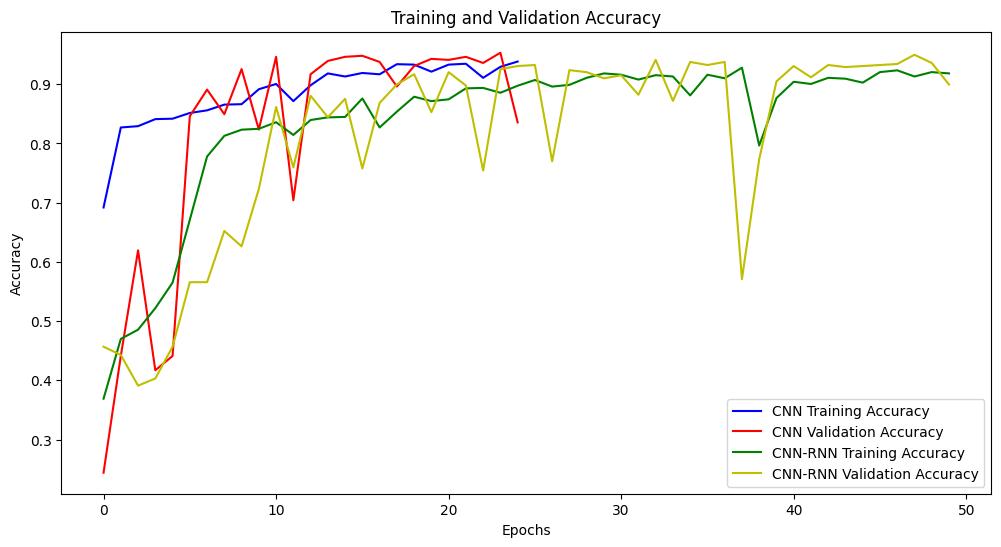

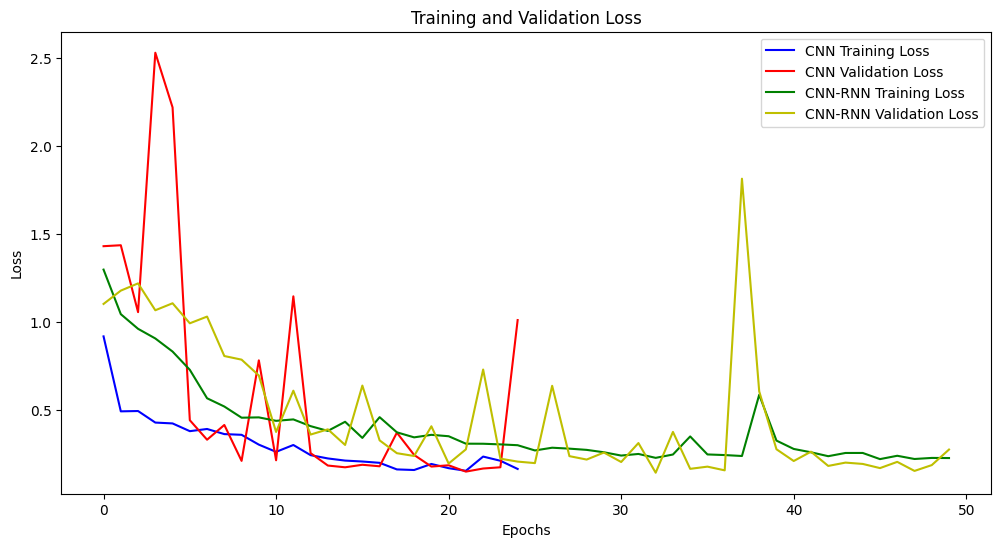

In [38]:
import matplotlib.pyplot as plt

# Extract metrics from history
accuracy_CNN = history_CNN['accuracy']
val_accuracy_CNN = history_CNN['val_accuracy']
loss_CNN = history_CNN['loss']
val_loss_CNN = history_CNN['val_loss']

accuracy_CNN_RNN = history_CNN_RNN['accuracy']
val_accuracy_CNN_RNN = history_CNN_RNN['val_accuracy']
loss_CNN_RNN = history_CNN_RNN['loss']
val_loss_CNN_RNN = history_CNN_RNN['val_loss']

# Debug prints to verify lengths and data
print("CNN Training Accuracy: ", accuracy_CNN)
print("CNN Validation Accuracy: ", val_accuracy_CNN)
print("CNN Training Loss: ", loss_CNN)
print("CNN Validation Loss: ", val_loss_CNN)

print("CNN-RNN Training Accuracy: ", accuracy_CNN_RNN)
print("CNN-RNN Validation Accuracy: ", val_accuracy_CNN_RNN)
print("CNN-RNN Training Loss: ", loss_CNN_RNN)
print("CNN-RNN Validation Loss: ", val_loss_CNN_RNN)

# Adjust epochs_CNN to match the length of val_accuracy_CNN
epochs_CNN = list(range(len(val_accuracy_CNN)))  # Changed this line
epochs_CNN_RNN = list(range(len(accuracy_CNN_RNN)))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, accuracy_CNN[:len(epochs_CNN)], "b", label="CNN Training Accuracy") # Changed this line
plt.plot(epochs_CNN, val_accuracy_CNN, "r", label="CNN Validation Accuracy")
plt.plot(epochs_CNN_RNN, accuracy_CNN_RNN, "g", label="CNN-RNN Training Accuracy")
plt.plot(epochs_CNN_RNN, val_accuracy_CNN_RNN, "y", label="CNN-RNN Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, loss_CNN[:len(epochs_CNN)], "b", label="CNN Training Loss") # Changed this line
plt.plot(epochs_CNN, val_loss_CNN, "r", label="CNN Validation Loss")
plt.plot(epochs_CNN_RNN, loss_CNN_RNN, "g", label="CNN-RNN Training Loss")
plt.plot(epochs_CNN_RNN, val_loss_CNN_RNN, "y", label="CNN-RNN Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# classification report

In [39]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [40]:
# Make predictions
predictions_CNN = best_model_CNN.predict(X_test)
predictions_CNN_RNN = best_model_CNN_RNN.predict(X_test)

# Convert predictions to label indices
predicted_classes_CNN = np.argmax(predictions_CNN, axis=1)
predicted_classes_CNN_RNN = np.argmax(predictions_CNN_RNN, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


In [41]:
from sklearn.metrics import classification_report
# Classification report for CNN
print("Classification Report for CNN:\n")
report_CNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN, target_names=labels_new)
print(report_CNN)

# Classification report for CNN-RNN
print("Classification Report for CNN-RNN:\n")
report_CNN_RNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN, target_names=labels_new)
print(report_CNN_RNN)

Classification Report for CNN:

              precision    recall  f1-score   support

        yawn       0.89      0.52      0.66        63
     no_yawn       0.38      0.99      0.55        74
      Closed       0.97      0.36      0.53       215
        Open       0.79      0.93      0.85       226

    accuracy                           0.68       578
   macro avg       0.76      0.70      0.65       578
weighted avg       0.82      0.68      0.67       578

Classification Report for CNN-RNN:

              precision    recall  f1-score   support

        yawn       0.55      0.75      0.64        63
     no_yawn       0.72      0.28      0.41        74
      Closed       0.65      0.10      0.18       215
        Open       0.52      0.99      0.68       226

    accuracy                           0.54       578
   macro avg       0.61      0.53      0.48       578
weighted avg       0.60      0.54      0.45       578



## Confusion matrix

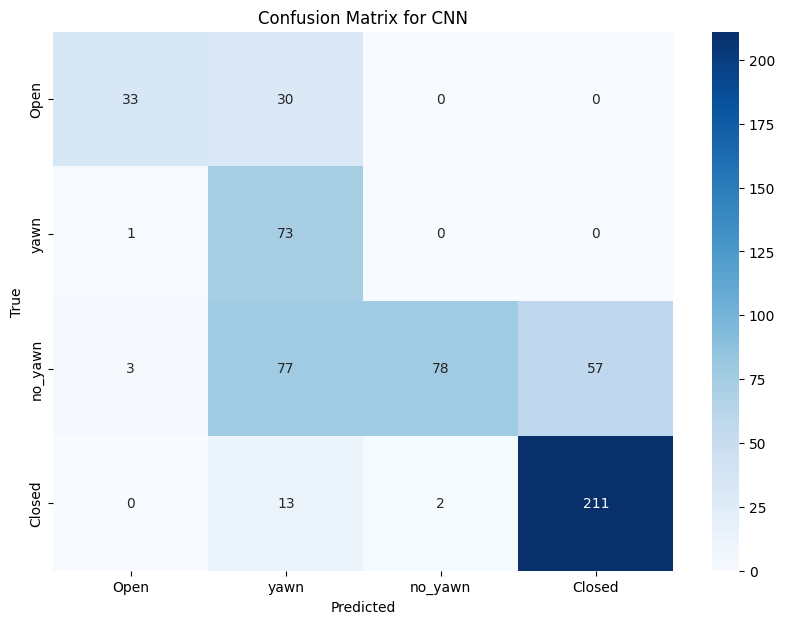

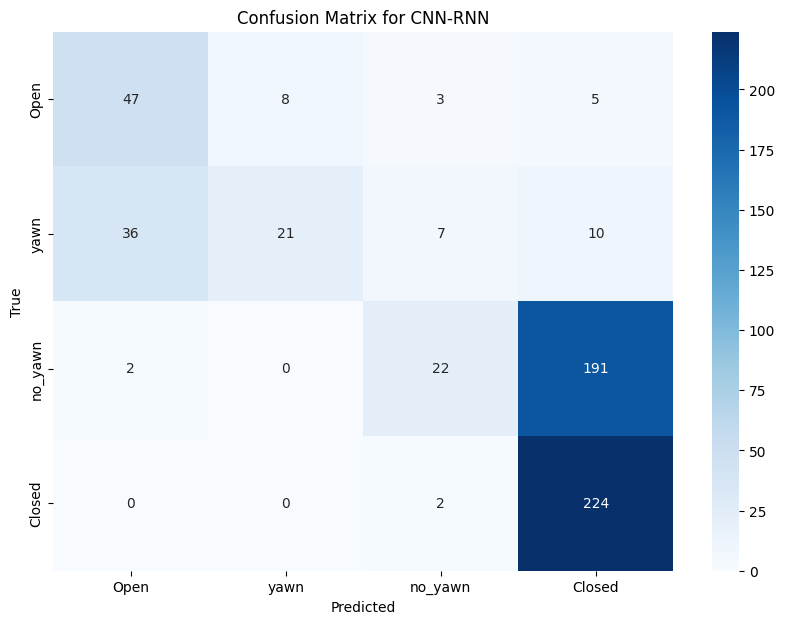

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrices
cm_CNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN)
cm_CNN_RNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, labels_new):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_new, yticklabels=labels_new)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Define class labels
labels_new = [ "Open","yawn", "no_yawn", "Closed",]

# Plot confusion matrices
plot_confusion_matrix(cm_CNN, "Confusion Matrix for CNN", labels_new)
plot_confusion_matrix(cm_CNN_RNN, "Confusion Matrix for CNN-RNN", labels_new)


# predicting function

In [44]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    except Exception as e:
        print("Error occurred while reading the image file:", e)
        return None

# Update the path to the correct location of your model file.
# This assumes the model is in "/content/drive/MyDrive/DrowsiScan/train/history_and_model/"
model = tf.keras.models.load_model("/content/drive/MyDrive/DrowsiScan/train/history_and_model/drowiness_new2.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/DrowsiScan/train/history_and_model/drowiness_new2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
prediction = model.predict([prepare(r"data\train\Closed\_100.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 239ms/step


2

In [ ]:
prediction = model.predict([prepare(r"data\train\Closed\_120.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 112ms/step


2

In [ ]:
prediction = model.predict([prepare(r"data\train\yawn\12.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 144ms/step


3